# Assigment

## Exploratory Data Analysis

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [150]:
# read data
X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data = pd.concat([X, Y], axis=1)

/tmp/ipykernel_35247/2748754953.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)


/tmp/ipykernel_35247/2748754953.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


In [151]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V1991,V1992,V1993,V1994,V1995,V1996,V1997,V1998,V1999,V2000
1,-1.168003,1.261756,-1.534537,-0.156028,-0.700344,3.985627,2.432774,0.767859,1.225563,-0.198581,...,-0.015099,-0.217915,0.123574,-3.209894,-1.26123,-1.676247,-0.8625,-1.103947,-1.109631,0.43515
2,-3.272103,-0.269244,-1.534537,-0.679228,-0.947544,0.794827,0.067374,0.033459,-0.010137,-0.198581,...,0.285601,-0.155615,1.044074,-3.209894,-2.37073,1.973753,-1.9055,-1.103947,-1.109631,0.89295
3,-0.861503,-0.189544,-1.534537,0.010572,-0.268144,1.808827,1.273274,-0.501841,0.753163,-0.198581,...,-1.816599,-0.217015,0.023974,-3.209894,-0.27183,0.245753,-1.2135,-1.103947,-1.109631,-0.45655
4,-0.595803,-0.580044,-1.534537,-0.107828,-0.475644,0.738027,-1.945726,0.476859,-0.010137,-0.198581,...,-0.532399,-0.402215,-0.410726,-3.209894,0.36967,1.586153,-0.5700,-1.103947,1.215569,0.45415
5,1.336097,0.360556,-1.534537,-0.097728,0.359656,-0.940173,0.378774,-0.271741,-0.010137,-0.198581,...,-0.894799,0.043385,0.273874,-0.747594,-0.46893,-0.481547,0.6180,-1.103947,-0.392031,-0.88775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,-2.407703,-0.630444,-1.534537,-0.746028,-0.615444,2.733027,-2.976926,0.433959,-0.010137,-0.198581,...,-1.537899,0.185685,-1.025226,2.214606,-0.20143,4.214753,-2.8351,2.170853,-1.109631,0.21915
2884,0.626397,0.546456,-1.534537,0.291672,1.228856,1.607627,-0.696826,-0.359341,-0.010137,-0.198581,...,-3.281399,-0.248515,-0.691026,0.352406,0.52507,3.099053,-2.4853,-1.103947,1.709069,-1.31475
2885,-0.247003,1.178056,-1.534537,-0.232828,1.647956,3.450627,-0.517526,0.094659,-0.010137,-0.198581,...,-2.792999,-0.121515,-0.475626,1.095506,-1.49993,3.473553,2.9253,-1.103947,1.492969,-0.15755
2886,-0.765003,-0.291644,-0.409837,-0.533628,2.256756,1.657427,-3.786426,-2.083541,-0.010137,-0.198581,...,0.963001,-0.013315,0.250774,0.400806,-0.51443,3.139053,-2.9320,-1.103947,-1.109631,0.11055


In [152]:
Y

,x
1,GBM
2,GBM
3,GBM
4,GBM
5,GBM
...,...
2883,U
2884,U
2885,U
2886,U


## Classes Distribution

<Axes: xlabel='x', ylabel='count'>

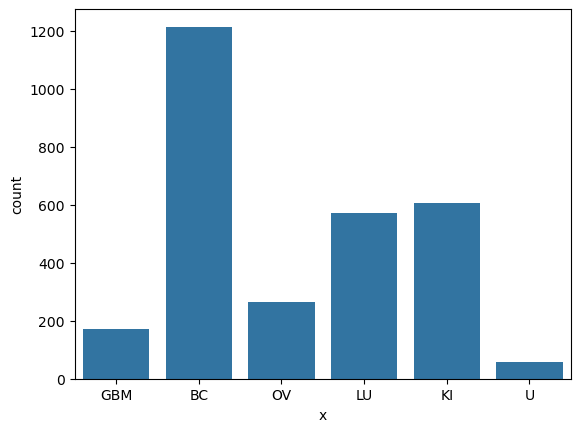

In [153]:
# hist of the class labels
sns.countplot(data=Y, x='x')

## Split Dataset, Define Classifiers and Folds

In [204]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(weights='uniform')
logistic = LogisticRegression(class_weight='balanced', C=1e-10, random_state=42)
rf = RandomForestClassifier(n_estimators=50,  class_weight='balanced', random_state=42)
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(50, 50))


## Train Dataset and Get Test Accuracy (Logistic)

In [155]:
pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', logistic)])

def test_train_logistic(gaussian_noise_factor=0):
    print('gaussian_noise_factor: ', gaussian_noise_factor)
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = Y_train + gaussian_noise_factor * noise    
    
    print('X_train_noisy.shape: ', X_train_noisy.shape)
    print('X_test.shape: ', X_test.shape)
    pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
    Y_test_pred_0 = pipeline_0.predict(X_test)
    print('logistic accuracy score: ', balanced_accuracy_score(Y_test, Y_test_pred_0))
    print('classification report: \n', classification_report(Y_test, Y_test_pred_0))
    print('\n\n')
    
test_train_logistic()  

gaussian_noise_factor:  0
X_train_noisy.shape:  (2598, 2000)
X_test.shape:  (289, 2000)
logistic accuracy score:  0.9225868730797222
classification report: 
               precision    recall  f1-score   support

          BC       1.00      0.69      0.82       121
         GBM       0.85      1.00      0.92        17
          KI       0.91      0.98      0.94        61
          LU       0.91      0.89      0.90        57
          OV       0.96      0.96      0.96        27
           U       0.17      1.00      0.29         6

    accuracy                           0.84       289
   macro avg       0.80      0.92      0.81       289
weighted avg       0.93      0.84      0.87       289






## Train Dataset and Get Test Accuracy (RF)

In [156]:


pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', rf)])

def test_train_rf(gaussian_noise_factor=0):
    print('gaussian_noise_factor: ', gaussian_noise_factor)
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = Y_train + gaussian_noise_factor * noise    
    
    print('X_train_noisy.shape: ', X_train_noisy.shape)
    print('X_test.shape: ', X_test.shape)
    pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
    Y_test_pred_0 = pipeline_0.predict(X_test)
    print('logistic accuracy score: ', balanced_accuracy_score(Y_test, Y_test_pred_0))
    print('classification report: \n', classification_report(Y_test, Y_test_pred_0))
    print('\n\n')
    
test_train_rf()  

gaussian_noise_factor:  0
X_train_noisy.shape:  (2598, 2000)
X_test.shape:  (289, 2000)
logistic accuracy score:  0.9355393645011132
classification report: 
               precision    recall  f1-score   support

          BC       0.97      1.00      0.98       121
         GBM       1.00      1.00      1.00        17
          KI       1.00      0.98      0.99        61
          LU       1.00      1.00      1.00        57
          OV       1.00      0.96      0.98        27
           U       1.00      0.67      0.80         6

    accuracy                           0.99       289
   macro avg       0.99      0.94      0.96       289
weighted avg       0.99      0.99      0.99       289






## Train Dataset and Get Test Accuracy (MLP)

In [157]:
pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', mlp)])

def test_train_mlp(gaussian_noise_factor=0):
    print('gaussian_noise_factor: ', gaussian_noise_factor)
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = Y_train + gaussian_noise_factor * noise    
    
    print('X_train_noisy.shape: ', X_train_noisy.shape)
    print('X_test.shape: ', X_test.shape)
    pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
    Y_test_pred_0 = pipeline_0.predict(X_test)
    print('logistic accuracy score: ', balanced_accuracy_score(Y_test, Y_test_pred_0))
    print('classification report: \n', classification_report(Y_test, Y_test_pred_0))
    print('\n\n')
    
test_train_mlp()  

gaussian_noise_factor:  0
X_train_noisy.shape:  (2598, 2000)
X_test.shape:  (289, 2000)
logistic accuracy score:  0.9938271604938271
classification report: 
               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       121
         GBM       1.00      1.00      1.00        17
          KI       0.98      1.00      0.99        61
          LU       1.00      1.00      1.00        57
          OV       1.00      0.96      0.98        27
           U       1.00      1.00      1.00         6

    accuracy                           1.00       289
   macro avg       1.00      0.99      1.00       289
weighted avg       1.00      1.00      1.00       289






## Train Dataset and Get Test Accuracy (KNN)

In [278]:
from sklearn.metrics import balanced_accuracy_score, classification_report


def test_train_knn(gaussian_noise_factor=0):
    noise = np.random.normal(0, 1, X_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn)])

    best_score = 0
    best_k = 0

    for k in [1, 3, 10, 50, 100, 300]:
        # knn.set_params(n_neighbors=k)
        pipeline_0.set_params(knn__n_neighbors=k)
        pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
        
        Y_pred = pipeline_0.predict(X_train_noisy)
        score = balanced_accuracy_score(Y_train, Y_pred)
        
        if  score > best_score:
            best_score = score
            best_k = k
        
        pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
        Y_test_pred_0 = pipeline_0.predict(X_test)
        print(k, score, balanced_accuracy_score(Y_test, Y_test_pred_0))
        print(classification_report(Y_test, Y_test_pred_0))
        print('\n\n')
        
    print('\n\n')
    print('Best training k:', best_k)
    print('Best training score:', best_score)

In [160]:
test_train_knn(0.9)

1 1.0 0.9938271604938271
              precision    recall  f1-score   support

          BC       0.99      1.00      1.00       121
         GBM       1.00      1.00      1.00        17
          KI       1.00      1.00      1.00        61
          LU       1.00      1.00      1.00        57
          OV       1.00      0.96      0.98        27
           U       1.00      1.00      1.00         6

    accuracy                           1.00       289
   macro avg       1.00      0.99      1.00       289
weighted avg       1.00      1.00      1.00       289




3 0.9847136565212837 0.9910949200566687
              precision    recall  f1-score   support

          BC       0.98      1.00      0.99       121
         GBM       1.00      1.00      1.00        17
          KI       1.00      0.98      0.99        61
          LU       1.00      1.00      1.00        57
          OV       1.00      0.96      0.98        27
           U       1.00      1.00      1.00         6

    accur

/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Part 1 - Dimension reduction and predictive modeling

### Assume optimal number of PC.

In [210]:
from sklearn.model_selection import StratifiedKFold


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2000)  
principal_components = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.8]) + 1
print(f"Number of components needed to explain 80% variance: {n_components_80}")
n_components_50 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.5]) + 1
print(f"Number of components needed to explain 50% variance: {n_components_50}")

Number of components needed to explain 80% variance: 226
Number of components needed to explain 50% variance: 15


<Axes: >

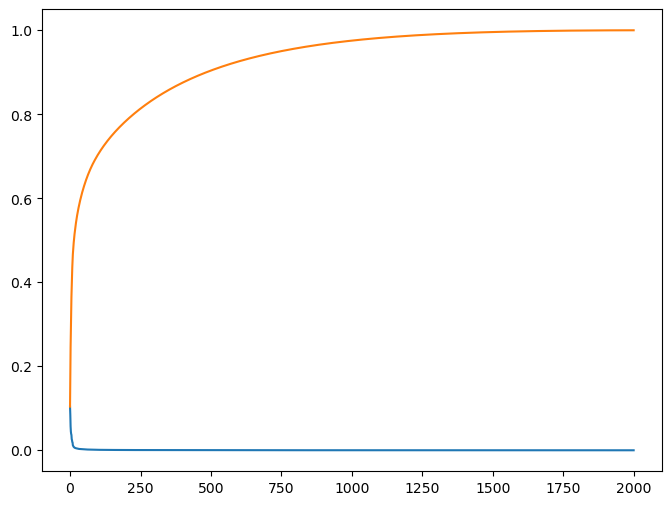

In [162]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=pca.explained_variance_ratio_)
sns.lineplot(data=cumulative_variance_ratios)

In [211]:
Y['x'].unique()
# assign a numbered label for Y
label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y['x'] = Y['x'].map(label_map)

### Task 1: Perform cross-validation to select the number of principal components that optimizing predictive performance.

In [271]:
parameters = {
    'pca__n_components': [500, 100, 50, 40, 35, 30, 25, 10],
    'knn__n_neighbors': [1, 10, 50, 100, 300]
}

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', knn)
])

In [279]:
from sklearn.metrics import classification_report, confusion_matrix

grid_search_1 = GridSearchCV(pipeline_1, parameters, cv=stratified_k_fold, n_jobs=-1, scoring="balanced_accuracy")
grid_search_1.fit(X_train, np.ravel(Y_train))

Y_test_pred_1 = grid_search_1.predict(X_test)
grid_search_1.best_estimator_
best_params_1 = grid_search_1.best_params_
print("Classification Report \nOptimal parameters - ",
      best_params_1['knn__n_neighbors'], " neighbors and ",
      best_params_1['pca__n_components'], "principal components:\n\n",
      classification_report(Y_test, Y_test_pred_1))

ValueError: Invalid parameter 'kbest' for estimator Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('knn', KNeighborsClassifier(n_neighbors=300))]). Valid parameters are: ['memory', 'steps', 'verbose'].

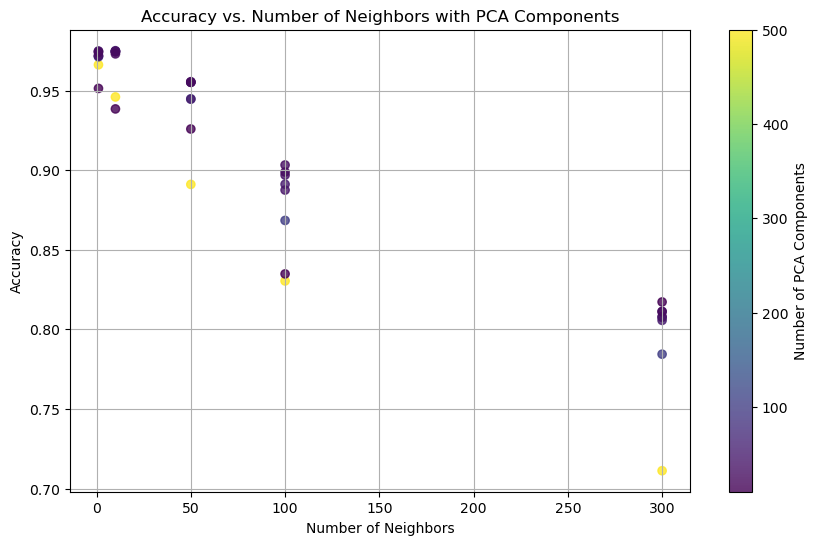

In [188]:
import matplotlib.pyplot as plt

cv_results = grid_search_1.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

neighbors = [params[i]['knn__n_neighbors'] for i in range(len(params))]
components = [params[i]['pca__n_components'] for i in range(len(params))]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(neighbors, mean_test_scores, c=components, cmap='viridis', alpha=0.8)
plt.colorbar(label='Number of PCA Components')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors with PCA Components')
plt.grid(True)
plt.show()

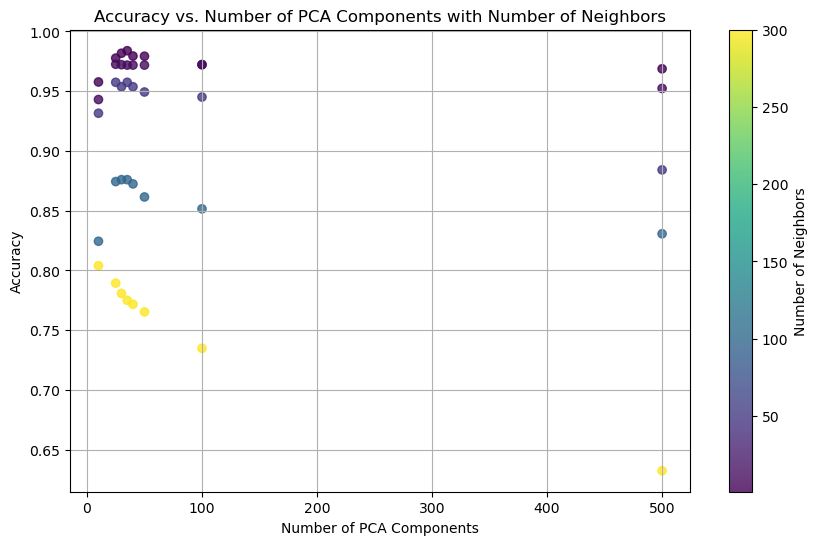

In [238]:
import matplotlib.pyplot as plt

cv_results = grid_search_1.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

neighbors = [params[i]['knn__n_neighbors'] for i in range(len(params))]
components = [params[i]['pca__n_components'] for i in range(len(params))]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(components, mean_test_scores, c=neighbors, cmap='viridis', alpha=0.8)
plt.colorbar(label='Number of Neighbors')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of PCA Components with Number of Neighbors')
plt.grid(True)
plt.show()

### Task 2: Perform cross-validation to select the number features (genes) that optimizing predictive performance.

In [273]:
# Create the RFECV model
from sklearn.feature_selection import RFECV
from sklearn.datasets import load_digits
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

classifier = knn

parameters = {
    'kbest__k': [250, 225, 200, 175, 150, 100, 75, 50, 40, 35, 30],
    'knn__n_neighbors': [1, 2, 3, 5, 7, 10, 50, 100, 300]
}

pipeline_2 = Pipeline([
    ('th', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif)),
    ('knn', knn)
])

In [274]:
from sklearn.metrics import classification_report, confusion_matrix

grid_search_2 = GridSearchCV(pipeline_2, parameters, cv=stratified_k_fold, n_jobs=-1, scoring="balanced_accuracy")
grid_search_2.fit(X_train, np.ravel(Y_train))

Y_test_pred_2 = grid_search_2.predict(X_test)
grid_search_2.best_estimator_
best_params_2 = grid_search_2.best_params_
print("Classification Report \nOptimal parameters - ",
      best_params_2['knn__n_neighbors'], " neighbors and ",
      best_params_2['kbest__k'], "variables:\n\n",
      classification_report(Y_test, Y_test_pred_2))

Classification Report 
Optimal parameters -  3  neighbors and  200 variables:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.99      1.00      1.00       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      1.00      1.00       121
           5       1.00      0.92      0.96        12

    accuracy                           1.00       578
   macro avg       1.00      0.98      0.99       578
weighted avg       1.00      1.00      1.00       578



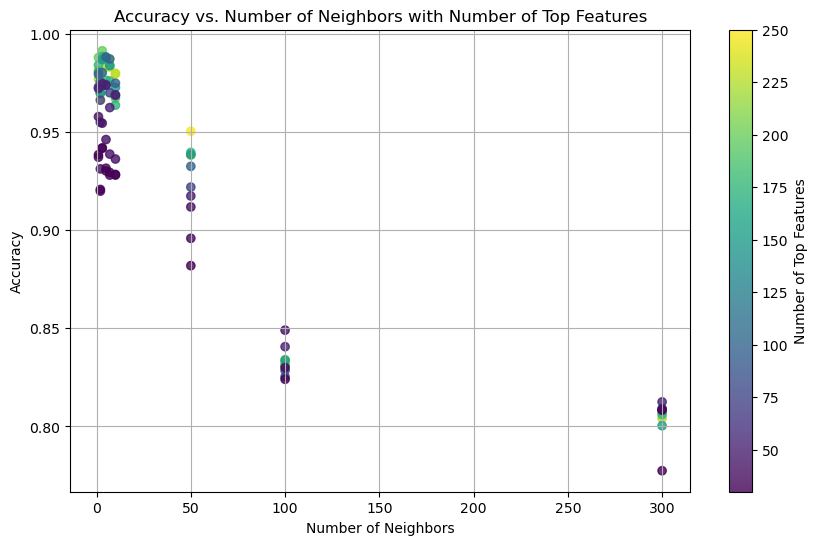

In [233]:
import matplotlib.pyplot as plt

cv_results = grid_search_2.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

neighbors = [params[i]['knn__n_neighbors'] for i in range(len(params))]
components = [params[i]['kbest__k'] for i in range(len(params))]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(neighbors, mean_test_scores, c=components, cmap='viridis', alpha=0.8)
plt.colorbar(label='Number of Top Features')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors with Number of Top Features')
plt.grid(True)
plt.show()

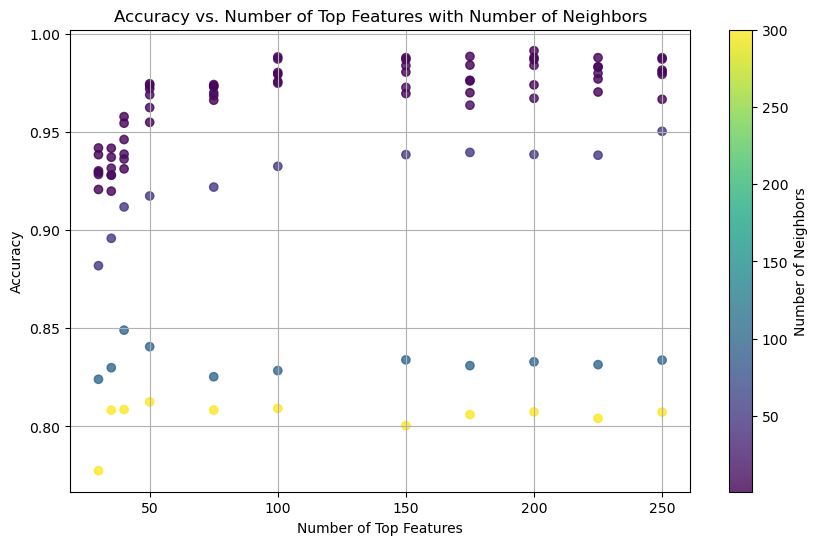

In [242]:
import matplotlib.pyplot as plt

cv_results = grid_search_2.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

neighbors = [params[i]['knn__n_neighbors'] for i in range(len(params))]
components = [params[i]['kbest__k'] for i in range(len(params))]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(components, mean_test_scores, c=neighbors, cmap='viridis', alpha=0.8)
plt.colorbar(label='Number of Neighbors')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features with Number of Neighbors')
plt.grid(True)
plt.show()

## Wrap-Up of Part 1

In [276]:
print("Top Principal Components:\nOptimal parameters - ",
      best_params_1['knn__n_neighbors'], " neighbors and ",
      best_params_1['pca__n_components'], "principal components:\n\n",
      classification_report(Y_test, Y_test_pred_1))

print("Top Features:\nOptimal parameters - ",
      best_params_2['knn__n_neighbors'], " neighbors and ",
      best_params_2['kbest__k'], "variables:\n\n",
      classification_report(Y_test, Y_test_pred_2))

Top Principal Components:
Optimal parameters -  1  neighbors and  30 principal components:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.99      0.99       243
           2       1.00      0.98      0.99        53
           3       0.97      0.99      0.98       114
           4       0.99      1.00      1.00       121
           5       1.00      0.92      0.96        12

    accuracy                           0.99       578
   macro avg       0.99      0.98      0.99       578
weighted avg       0.99      0.99      0.99       578

Top Features:
Optimal parameters -  3  neighbors and  200 variables:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.99      1.00      1.00       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.0

## Part 2: mislabeling

In [307]:
def apply_mislabeling(Y_train, percentage):
    num_samples = Y_train.shape[0]
    num_mislabeled_samples = int(num_samples * percentage)
    mislabeled_indices = np.random.choice(num_samples, num_mislabeled_samples, replace=False)
    for idx in mislabeled_indices:
        original_label = Y_train.iloc[idx]
        # ensure that the new label is different from the original one
        replacement_choices = np.setdiff1d([0, 1, 2, 3, 4, 5], [original_label])
        new_label = np.random.choice(replacement_choices)
        Y_train.iloc[idx] = new_label
    return Y_train

In [311]:
def train_test_knn_mislabel(gaussian_noise_factor=0):
    noise = np.random.normal(0, 1, X_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    
    pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn)])

    mislabeling_percs = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plt.figure(figsize=(10, 6))
    for k in [1, 3, 10, 50, 100, 300]:
        mislabeling_results = []
        for percentage in mislabeling_percs:
            Y_train_mislabel = Y_train.copy()
            Y_train_mislabel = apply_mislabeling(Y_train_mislabel, percentage)
            pipeline_0.set_params(knn__n_neighbors=k)
            pipeline_0.fit(X_train_noisy, np.ravel(Y_train_mislabel))
            Y_test_pred_0 = pipeline_0.predict(X_test)
            mislabeling_results.append(balanced_accuracy_score(Y_test, Y_test_pred_0))
            
        # plot the results
        plt.plot(mislabeling_percs, mislabeling_results, label=f'k={k}')
        plt.xlabel('Percentage of mislabeled samples')
        plt.ylabel('Balanced accuracy')
        plt.legend()

        
train_test_knn_mislabel()